In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import pickle
import pandas as pd
import sys
sys.path.insert(0, "../SyMBac/") 
from SyMBac.drawing import raster_cell, OPL_to_FL, convert_to_3D
from SyMBac.PSF import PSF_generator
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from SyMBac.renderer import convolve_rescale
from tqdm.auto import tqdm
from skimage import color, data, restoration
from matplotlib.colors import LogNorm
from joblib import Parallel, delayed



In [41]:
pix_mic_conv = 0.005
resize_amount = 1

In [42]:
cell_length = 3 #micron
cell_width = 1 #micron
raster_cell_length = cell_length / pix_mic_conv
raster_cell_width = cell_width / pix_mic_conv
def raster_membrane_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount = False):


    membrane_thickness = 0.1 #micron
    raster_membrane_thickness = membrane_thickness/pix_mic_conv * resize_amount
    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, separation=0)
    cell_2 = raster_cell(length=round((raster_cell_length - raster_membrane_thickness)/2)*2, width=round((raster_cell_width - raster_membrane_thickness)/2)*2, separation=0)

    cell_1_3d = convert_to_3D(cell_1)
    cell_2_3d = convert_to_3D(cell_2)

    
    pad_1 = int((cell_1_3d.shape[0] - cell_2_3d.shape[0])/2)
    pad_2 = int((cell_1_3d.shape[1] - cell_2_3d.shape[1])/2)
    pad_3 = int((cell_1_3d.shape[2] - cell_2_3d.shape[2])/2)

    cell_2_3d = np.pad(cell_2_3d, ((pad_1,pad_1), (pad_2, pad_2), (pad_3, pad_3)))
    
    cell_3d = cell_1_3d - cell_2_3d
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

In [43]:
raster_cell_width

200.0

In [44]:
wavelengths = [0.47, 0.584]
membrane_cell = np.pad(raster_membrane_cell_3d(raster_cell_length,raster_cell_width), ((1,1),(300,300),(400,400)))
print(membrane_cell.shape)

(200, 1200, 1000)


In [45]:
def conv_membrane_wavelength(wavelength):
    my_kernel = PSF_generator(
        radius = 100, 
        wavelength = wavelength, 
        NA=1.49, 
        n = 1.518, 
        resize_amount=1, 
        pix_mic_conv=pix_mic_conv, 
        apo_sigma = 10, 
        mode="3d fluo", 
        condenser="Ph3", 
        z_height = int(raster_cell_width),
        pz = .5,
        working_distance = 170
    )
    my_kernel.calculate_PSF()   
    
    conv_3d = np.array([convolve_rescale(membrane_cell_layer.astype(float), real_PSF_layer, 1, False) for membrane_cell_layer, real_PSF_layer in zip(tqdm(membrane_cell), my_kernel.kernel)])
    return my_kernel, conv_3d

In [46]:
kernels, convs = zip(*Parallel(n_jobs=-1)(delayed(conv_membrane_wavelength)(wavelength) for wavelength in wavelengths))

100%|██████████| 200/200 [03:24<00:00,  1.02s/it]


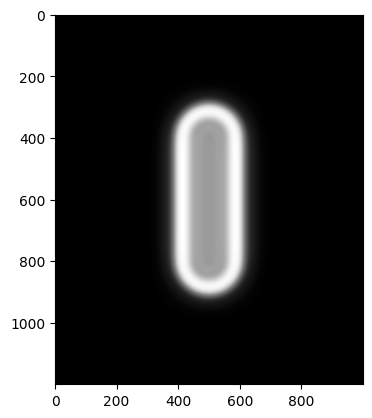

In [47]:
plt.imshow(convs[-1].sum(axis=0), cmap="Greys_r")

In [48]:
from cucim.skimage.restoration import richardson_lucy as richardson_lucy_cuda
import cupy as cp

In [49]:
membrane_cell_cropped = membrane_cell.sum(axis=0)[300:-300,380:-380]
membrane_cell_profile = membrane_cell_cropped[250:350,:].sum(axis=0)

In [50]:


conv_profiles = []
deconv_profiles = []
for conv, kernel in zip(tqdm(convs), kernels):
    conv_profile = conv.sum(axis=0)[300:-300,380:-380][250:350,:].mean(axis=0)
    
    deconv_img_lorentz = richardson_lucy_cuda(cp.array(conv.sum(axis=0)/conv.sum(axis=0).sum()), cp.array(kernel.kernel.sum(axis=0)),5000).get()
    deconv_img_lorentz = deconv_img_lorentz[300:-300,380:-380]
    deconv_profile = deconv_img_lorentz[250:350,:].mean(axis=0)
    
    conv_profiles.append(conv_profile)
    deconv_profiles.append(deconv_profile)
    
    



  0%|          | 0/2 [00:00<?, ?it/s]

In [1]:
plt.imshow(conv.sum(axis=0))

NameError: name 'plt' is not defined

In [52]:
from scipy.signal import find_peaks

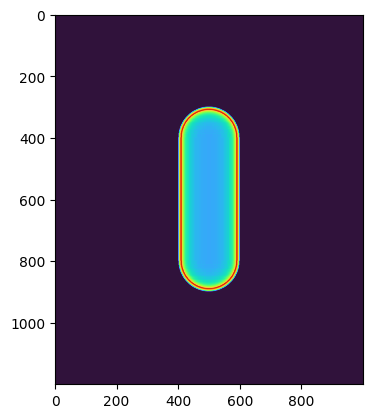

In [53]:
plt.imshow(membrane_cell.sum(axis=0), cmap="turbo")

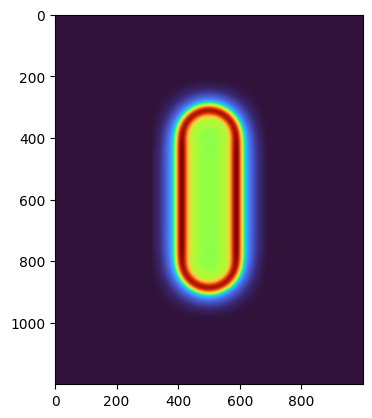

In [54]:
plt.imshow(convs[0].sum(axis=0), cmap="turbo")

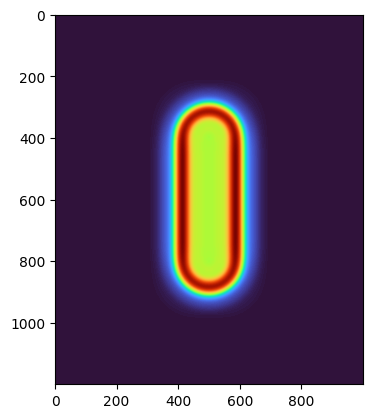

In [55]:
plt.imshow(convs[1].sum(axis=0), cmap="turbo")

208
206


(200.0, 220.0)

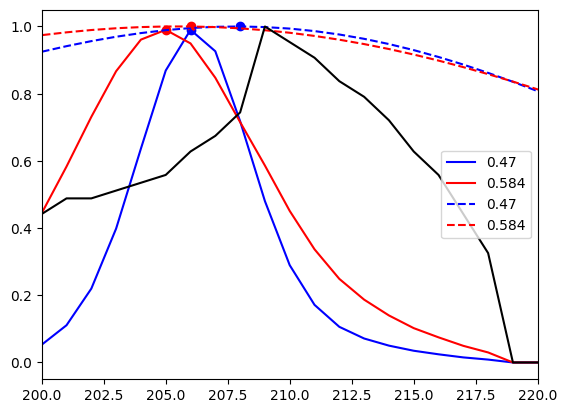

In [57]:
colors = ["b", "r"]
for deconv_profile, wavelength, c in zip(deconv_profiles, wavelengths, colors):
    deconv_profile = deconv_profile/deconv_profile.max()*0.99
    peak = find_peaks(deconv_profile)[0][-1]
    plt.plot(deconv_profile, label = wavelength, c = c)
    plt.scatter(peak, deconv_profile[peak], c = c)
    plt.legend()

for conv_profile, wavelength, c in zip(conv_profiles, wavelengths, colors):
    conv_profile = conv_profile/conv_profile.max()
    peak = find_peaks(conv_profile)[0][-1]
    print(peak)
    plt.plot(conv_profile/conv_profile.max(), label = wavelength, c = c, linestyle="--")
    plt.scatter(peak, conv_profile[peak], c = c)
    plt.legend()

plt.plot(membrane_cell_profile/membrane_cell_profile.max(), c = "k")
plt.xlim(200,220)
#plt.ylim(0.8,1.1)

In [58]:
2*pix_mic_conv

0.01